## Word2Vec Embeddings and Clustering

In this section, we use **Word2Vec** to transform book quotes into numerical vectors that capture their meaning. These word embeddings help us understand the **semantic similarity** between different quotes.

Once we have the vector representations:
- We apply **KMeans clustering** to group similar quotes into 10 clusters.
- Each cluster represents a different **theme or topic** based on the meaning of the quotes.
- This allows us to **analyze** and **organize** the quotes in a meaningful way.
- Finally, we use **PCA (Principal Component Analysis)** to reduce the vector dimensions to 2D so we can **visualize** the clusters.

This step is important because it helps us:
- Discover hidden structures and patterns in the data
- Better understand the types of quotes users might like
- Prepare the data for recommendation systems and user queries

This forms the foundation for building a more personalized and intelligent quote recommendation system.


In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


df = pd.read_csv("quotes.csv", sep=';', engine='python', on_bad_lines='skip')

df.dropna(subset=['quote'], inplace=True)
df = df[df['quote'].str.strip().astype(bool)]
df.head()

,quote,author,title,likes,tags
0,"If you want to know what a man's like, take a ...",J.K. Rowling,Harry Potter and the Goblet of Fire,95186,NaN
1,Don’t walk in front of me… I may not follow,Albert Camus,NaN,84930,"friends, friendship, misattributed-albert-camus"
2,Friendship ... is born at the moment when one ...,C.S. Lewis,The Four Loves,83698,NaN
3,I am so clever that sometimes I don't understa...,Oscar Wilde,The Happy Prince and Other Stories,67183,self-deprecation
4,"Without music, life would be a mistake. \n ―",Friedrich Nietzsche,Twilight of the Idols,66263,"music, philosophy"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /home/hakimim1/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hakimim1/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Text Cleaning & Tokenization

Now we prepare the quote texts for Word2Vec modeling:

- Reset the dataframe index
- Download English stopwords
- Define a `preprocess()` function to:
  - Lowercase and tokenize the text
  - Remove punctuation and non-alphabetic words
  - Filter out common stopwords
- The result is saved in a new column `tokens`, which contains clean word lists for each quote.


In [3]:
df.reset_index(drop=True, inplace=True)

stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    
    tokens = [word for word in tokens if word.isalpha()]
    
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

df['tokens'] = df['quote'].apply(preprocess)

df.head()


,quote,author,title,likes,tags,tokens
0,"If you want to know what a man's like, take a ...",J.K. Rowling,Harry Potter and the Goblet of Fire,95186,NaN,"[want, know, man, like, take, good, look, trea..."
1,Don’t walk in front of me… I may not follow,Albert Camus,NaN,84930,"friends, friendship, misattributed-albert-camus","[walk, front, may, follow]"
2,Friendship ... is born at the moment when one ...,C.S. Lewis,The Four Loves,83698,NaN,"[friendship, born, moment, one, man, says, ano..."
3,I am so clever that sometimes I don't understa...,Oscar Wilde,The Happy Prince and Other Stories,67183,self-deprecation,"[clever, sometimes, understand, single, word, ..."
4,"Without music, life would be a mistake. \n ―",Friedrich Nietzsche,Twilight of the Idols,66263,"music, philosophy","[without, music, life, would, mistake]"


##  Word2Vec Model Training

With all quotes preprocessed into tokens, we now:

- Create a list of all tokenized sentences
- Train a `Word2Vec` model using:
  - `vector_size=100`: dimensionality of word vectors
  - `window=5`: context window size
  - `min_count=2`: ignore rare words
  - `workers=4`: use 4 threads


In [4]:
sentences = df['tokens'].tolist()

model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


## Creating Quote Vectors

Each quote is now represented by the average of its word vectors:

- A function `get_mean_vector()` calculates the mean Word2Vec vector for all valid tokens
- If none of the tokens are in the model’s vocabulary, a zero-vector is returned
- The output is stored in a new column `vector`


In [5]:
def get_mean_vector(tokens, model):
    valid_tokens = [token for token in tokens if token in model.wv]
    
    if not valid_tokens:
        return np.zeros(model.vector_size)
    
    return np.mean([model.wv[token] for token in valid_tokens], axis=0)

df['vector'] = df['tokens'].apply(lambda tokens: get_mean_vector(tokens, model))


###  Example: Finding Similar Quotes

Let's test how Word2Vec can be used to find quotes that are **semantically similar** to a query.

- In this case, our query is: **"I love you"**
- The system:
  - Preprocesses the query
  - Converts it into a Word2Vec vector
  - Compares it to all quotes in the dataset using **cosine similarity**
- We then sort and display the **top 30 most similar quotes**.

 This shows how we could build a **quote recommendation engine**, where a user types a sentence and receives related or meaningful quotes in return.


In [6]:

query = "I love you"
query_tokens = preprocess(query)
query_vector = get_mean_vector(query_tokens, model).reshape(1, -1)

quote_vectors = np.vstack(df['vector'].values)
similarities = cosine_similarity(query_vector, quote_vectors)

df['similarity'] = similarities[0]
top_quotes = df.sort_values(by='similarity', ascending=False).head(30)

top_quotes[['quote', 'author', 'similarity']]


,quote,author,similarity
312608,And she was in love.,Jonathan Safran Foer,1.000000
229485,"If there is no love, what then?2",Walter Isaacson,1.000000
162669,I love whom I love,Peter S. Beagle,1.000000
18838,Don’t do it. Don’t love me.,Charles Bukowski,1.000000
71115,I love you.Thorns and All. \n ―,Sarah J. Maas,1.000000
27281,Love. That was what she had that IT did not have.,Madeleine L'Engle,1.000000
255647,"love you if I cannot love myself, he",Robin S. Sharma,1.000000
265496,Love was love.,Barbara Delinsky,1.000000
100264,I love...being with you.,Lisa Renee Jones,1.000000
195485,Love is not for the undepilated.,Alice Munro,1.000000


### Grouping Similar Quotes Using Word2Vec and KMeans

After converting all quotes into Word2Vec vectors , we can now try to find groups of similar quotes.

To do this, we use a method called **KMeans clustering**. It helps us:
- Group quotes that have similar meanings or topics.
- Spot patterns or common themes in the data.
- Organize a large amount of text into smaller, more meaningful groups.

We set the number of clusters to 10.

We also:
- Show a few example quotes from each cluster so you can see what's inside.
- Create a 2D plot using something called **PCA**, which helps us **visualize the clusters** in a simple scatter plot.
  - Each dot is a quote.
  - Dots with the same color belong to the same group.




/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



--- Cluster 0 ---


,quote
1,Don’t walk in front of me… I may not follow
2,Friendship ... is born at the moment when one ...
4,"Without music, life would be a mistake. \n ―"
11,It is better to remain silent at the risk of b...
17,"Outside of a dog, a book is man's best friend...."



--- Cluster 1 ---


,quote
92,Just because you have the emotional range of a...
103,Being a woman is a terribly difficult trade si...
105,I am no bird. and no net ensnares me: I am a f...
106,I am no bird. and no net ensnares me: I am a f...
127,"We are only as strong as we are united, as wea..."



--- Cluster 2 ---


,quote
5812,The entrance to the Underworld is in Los Angeles.
10770,Il n'y a de réalité que dans l'action.\n(There...
11785,"I vill now destroy de Snickuhs bahs!""-Gazzy"
11831,"La cucaracha, La cucaracha, Ya no puede camina..."
12049,"El que lee mucho y anda mucho, ve mucho y sabe..."



--- Cluster 3 ---


,quote
6,Twenty years from now you will be more disappo...
7,"All that is gold does not glitter,\nNot all th..."
40,"Love looks not with the eyes, but with the min..."
62,"Dumbledore watched her fly away, and as her si..."
84,Memories warm you up from the inside. But they...



--- Cluster 4 ---


,quote
59,"He's like a drug for you, Bella. \n ―"
79,Books are a uniquely portable magic. \n ―
130,Mr. Moony presents his compliments to Professo...
134,He can run faster than Severus Snape confronte...
197,Faithless is he that says farewell when the ro...



--- Cluster 5 ---


,quote
16,I solemnly swear that I am up to no good.
33,"Of course it is happening inside your head, Ha..."
70,"[Dean] My dear fellow, who will let you?\n[Roa..."
83,Do you remember me telling you we are practici...
136,Is it true that you shouted at Professor Umbri...



--- Cluster 6 ---


,quote
0,"If you want to know what a man's like, take a ..."
3,I am so clever that sometimes I don't understa...
5,We accept the love we think we deserve. \n ―
15,"I may not have gone where I intended to go, bu..."
18,"Love all, trust a few, do wrong to none."



--- Cluster 7 ---


,quote
9,"The person, be it gentleman or lady, who has n..."
32,"Sometimes, you read a book and it fills you wi..."
43,The story so far:\nIn the beginning the Univer...
49,We’re all a little weird. And life is a little...
50,"I would venture to guess that Anon, who wrote ..."



--- Cluster 8 ---


,quote
3068,La plus belle des ruses du diable est de vous ...
3828,"Et tu, Brute?"
4979,Nolite te bastardes carborundorum.
5967,[E]xceptional claims demand exceptional evidence.
6132,L'amor che move il sole e l'altre stelle.



--- Cluster 9 ---


,quote
8,"It is our choices, Harry, that show what we tr..."
10,It does not do to dwell on dreams and forget t...
12,"The fool doth think he is wise, but the wise m..."
13,Fairy tales are more than true: not because th...
14,Fairy tales are more than true: not because th...


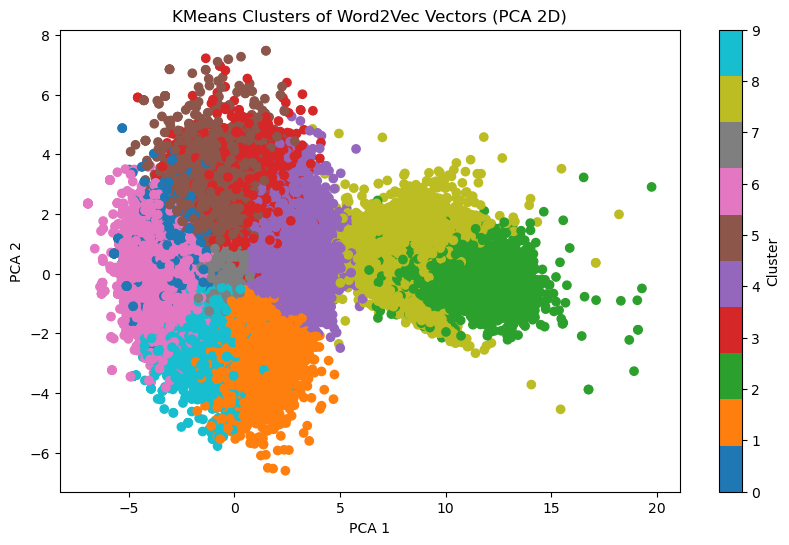

In [7]:

X = np.vstack(df['vector'].values)

# Set the number of clusters
n_clusters = 10

# KMeans searches for similarities between vectors 
# and groups them into 'n_clusters' number of clusters.

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Check what kind of quotes each cluster contains
for i in range(n_clusters):
    print(f"\n--- Cluster {i} ---")
    display(df[df['cluster'] == i][['quote']].head(5))

#Visualize the clusters in 2D using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10')
plt.title('KMeans Clusters of Word2Vec Vectors (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()




####  What the results show:
- Quotes were grouped into different **thematic clusters** based on their vector similarity.
#### Cluster 0 – Fantasy, Magic & Emotional Intensity
- Quotes related to fantasy worlds, magical elements, or deep emotional bonds.
- Includes references to fictional universes like Harry Potter and mystical language.

#### Cluster 1 – Inspirational & Life Wisdom
- Motivational and reflective quotes focused on how to live well or see the world differently.
- Includes travel, imagination, and philosophical musings.

#### Cluster 2 – Multilingual, Surreal, or Random Humor
- Quotes in different languages (e.g., French, Spanish) and quirky or surreal humor.
- Contains unexpected or abstract content from diverse sources.

#### Cluster 3 – Classic Wisdom & Fairy Tales
- Philosophical insights, moral lessons, and timeless quotes.
- Strong presence of classic literature, Shakespeare, and fairy tale logic.

#### Cluster 4 – Literary, Historical & Poetic References
- High-literary or historical tone with Latin quotes, famous phrases, and poetic expressions.
- Includes themes of existence, truth, and intellectual critique.

#### Cluster 5 – Friendship, Music & Everyday Philosophy
- Warm, human-centered quotes about companionship, music, silence, and books.
- Focuses on connection, introspection, and shared experience.

#### Cluster 6 – Feminist, Empowering & Unity-Focused
- Quotes about strength, freedom, feminism, and emotional depth.
- Repetition of powerful affirmations and group solidarity messages.

#### Cluster 7 – Love, Magic, and Bittersweet Reflections
- Blends romantic, magical, and memory-driven quotes.
- Includes literary themes with feelings of longing or wonder.

#### Cluster 8 – Self-Reflection & Emotional Truths
- Quotes about love, identity, acceptance, and emotional complexity.
- Often introspective or philosophically light-hearted.

#### Cluster 9 – Mischief, Humor & School-like Magic
- Playful, school-themed quotes often with references to magical learning or mischief.
- Has a strong Harry Potter influence and energetic, youthful tone.

This means that Word2Vec successfully captured some **semantic patterns** in the text — even though it only works at the word level.

####  The visualization (PCA plot):
- Shows the quotes in 2D space.
- Dots that are close together represent quotes with similar meanings.
- Colors show different clusters (groups of related quotes).
- We can clearly see how quotes are **naturally separated** into different regions in the plot.

---

### Limitations of Word2Vec

While Word2Vec gives us a useful way to group similar quotes and understand semantic relationships between words, it also has some important weaknesses — especially when used for tasks like **recommendation** or **understanding deeper meaning** in quotes.

Here are some of the main limitations:

- **No understanding of context**  
  Word2Vec assigns the same vector to a word no matter where it appears.  
  For example, the word *"light"* in *"light a candle"* and *"light as a feather"* gets the same representation, even though the meaning is different.

- **Cannot handle sentence-level meaning**  
  Since it works at the word level, Word2Vec doesn't truly "understand" the full meaning of a sentence or quote.  
  For instance, it might place *"I hate you"* and *"I love you"* close together because they share similar words.

- **Fails at detecting tone or sentiment**  
  Word2Vec doesn't distinguish between **positive** and **negative** emotions.  
  For example, it might group *"Life is beautiful"* with *"Life is painful"* just because of shared words.

- **Ignores grammar and structure**  
  Word2Vec doesn’t take into account **word order** or **sentence grammar**, which can be crucial for understanding nuanced or poetic quotes.

-  **Cannot handle unseen or rare words well**  
  If a word wasn’t in the training data, Word2Vec has no vector for it — meaning it can’t process the sentence properly.

---

###  What this means for our project

These limitations suggest that while Word2Vec is a **good starting point**, it’s not enough for tasks that need deeper language understanding — like **personalized recommendations** or detecting **tone and emotion** in quotes.

That’s why in the next steps, we’ll move toward more advanced models like **BERT**, which can generate **context-aware sentence embeddings** and provide more accurate results for recommendation systems..


In [8]:
# Save embeddings and cluster labels to a CSV file
output_file = "quotes_with_clusters.csv"
df_to_save = df[['quote', 'tokens', 'vector', 'cluster']].copy()

# Convert the vector column (numpy arrays) to strings for saving
df_to_save['vector'] = df_to_save['vector'].apply(lambda x: ','.join(map(str, x)))

# Save to CSV
df_to_save.to_csv(output_file, index=False)
print(f"Quotes with clusters saved to {output_file}")

Quotes with clusters saved to quotes_with_clusters.csv


In [9]:
# Save embeddings (without clusters) to a CSV file
output_file = "quotes_with_vectors.csv"
df_to_save = df[['quote', 'tokens', 'vector']].copy()

# Convert the vector column (numpy arrays) to strings for saving
df_to_save['vector'] = df_to_save['vector'].apply(lambda x: ','.join(map(str, x)))

# Save to CSV
df_to_save.to_csv(output_file, index=False)
print(f"Quotes with vectors saved to {output_file}")


Quotes with vectors saved to quotes_with_vectors.csv
